In [367]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

from utils import device_setting, seed_torch, image_check
from data_manager import AnomalyDataManager
from model import MLP, AutoEncoder
from metric_layer import ArcMarginProduct#, MetricModel
# from resnet import ResNet18
# from trainer import Trainer

import matplotlib.pyplot as plt
import torchvision.utils as v_utils

from sklearn.manifold import TSNE
import numpy as np
import matplotlib

import copy
from statistics import mean

In [368]:
data_dir = '../data'
dataset = 'mnist'
batch_size = 64
lr = 0.001
momentum = 0.9
max_epoch = 200
criterion = nn.MSELoss(reduction='none')
feature_dim = 10
gpu = 0
device = device_setting(gpu=gpu)
anomaly_setting = 0
seed = 0
data_manager = AnomalyDataManager(dataset=dataset, data_dir=data_dir, trans=None, seed=seed, only_normal=False, anomaly_setting=anomaly_setting, data_num=2000)

train data: 1600


In [369]:
num_classes = data_manager.get_num_classes()
dataloader_dict = data_manager.build_dataloader(batch_size)

In [370]:
model = AutoEncoder(in_dims=data_manager.input_dim, latent_dims=feature_dim)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=784, bias=True)
  )
)

In [371]:
seed_torch(0)
model = AutoEncoder(in_dims=data_manager.input_dim, latent_dims=feature_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='none')

load_epoch = 999
model_path = '../models/{}/anomaly_setting_{}/emb_size_{}/model_epoch_{}.pth'.format(dataset, anomaly_setting, feature_dim, load_epoch)
model.load_state_dict(torch.load(model_path))

model = model.to(device)

In [372]:
model.set_threshold(dataloader_dict['train'], criterion, device, thres='mean')

set Threshold : 0.113316765637137


In [373]:
model.threshold = 0.30

In [374]:
for i, (data, label) in enumerate(dataloader_dict['train']):
    data = data.reshape(-1, 28*28).to(device)
    y_hat, fe = model(data)
    # plt.imshow(y_hat.cpu().detach().numpy()[0])
    break

In [375]:
label.unique()

tensor([4])

In [355]:
gen = y_hat.cpu().reshape(-1, 1, 28, 28)
gen.shape

torch.Size([64, 1, 28, 28])

In [356]:
v_utils.save_image(data.cpu().reshape(-1, 1, 28, 28)[0:25],"../results/anomaly_setting_{}/emb_size_{}/normal_data.png".format(anomaly_setting, feature_dim), nrow=5)
v_utils.save_image(gen.data[0:25],"../results/anomaly_setting_{}/emb_size_{}/normal_gen_epoch{}.png".format(anomaly_setting, feature_dim, load_epoch+1), nrow=5)

In [376]:
# 異常データの生成
label = dataloader_dict['test'].dataset.targets
if anomaly_setting == 0:
    normal_mask = (label == 4)
    anomaly_mask = (label != 4)
elif anomaly_setting == 1:
    normal_mask = (label % 2 == 0)
    anomaly_mask = (label % 2 != 0)
elif anomaly_setting == 2:
    normal_mask = (label != 9)
    anomaly_mask = (label == 9)
else:
    normal_mask = (label >= 0)
    anomaly_mask = (label < 0)

In [377]:
normal_mask

tensor([False, False, False,  ...,  True, False, False])

In [378]:
normal_mask == False

tensor([ True,  True,  True,  ..., False,  True,  True])

In [358]:
label.unique()

tensor([0, 1, 2, 3, 5, 6, 7, 8, 9])

In [359]:
label[anomaly_mask].unique()

tensor([0, 1, 2, 3, 5, 6, 7, 8, 9])

In [360]:
dataloader_dict['test'].dataset.data = dataloader_dict['test'].dataset.data[anomaly_mask]
dataloader_dict['test'].dataset.targets = dataloader_dict['test'].dataset.targets[anomaly_mask]

In [361]:
dataloader_dict['test'].dataset.targets.unique()

tensor([0, 1, 2, 3, 5, 6, 7, 8, 9])

In [362]:
for i, (data, label) in enumerate(dataloader_dict['test']):
    data = data.reshape(-1, 28*28).to(device)
    y_hat, fe = model(data)
    # plt.imshow(y_hat.cpu().detach().numpy()[0])
    break

In [363]:
label

tensor([7, 2, 1, 0, 1, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 9, 6, 6, 5, 0, 7, 0,
        1, 3, 1, 3, 7, 2, 7, 1, 2, 1, 1, 7, 2, 3, 5, 1, 2, 6, 3, 5, 5, 6, 0, 1,
        9, 5, 7, 8, 9, 3, 7, 6, 3, 0, 7, 0, 2, 9, 1, 7])

In [364]:
gen = y_hat.cpu().reshape(-1, 1, 28, 28)
gen.shape

torch.Size([64, 1, 28, 28])

In [365]:
v_utils.save_image(data.cpu().reshape(-1, 1, 28, 28)[0:25],"../results/anomaly_setting_{}/emb_size_{}/anomaly_data.png".format(anomaly_setting, feature_dim, load_epoch+1), nrow=5)

In [366]:
v_utils.save_image(gen.data[0:25],"../results/anomaly_setting_{}/emb_size_{}/anomaly_gen_epoch{}.png".format(anomaly_setting, feature_dim, load_epoch+1), nrow=5)

In [16]:
# しきい値を変えた性能テスト
miss_data_dict = {}
miss_loss_dict = {}
for th in [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]:
    normal_acc = 0
    losses = []
    miss_data = []
    miss_loss = []
    model.threshold = th
    for data, label in dataloader_dict['test']:
        data = data.reshape(-1, data_manager.input_dim)
        data = data.to(device)
        label = label.to(device)
        if anomaly_setting == 0:
            normal_mask = (label == 4)
            anomaly_mask = (label != 4)
        elif anomaly_setting == 1:
            normal_mask = (label == 0)
            anomaly_mask = (label != 0)
        elif anomaly_setting == 2:
            normal_mask = (label != 9)
            anomaly_mask = (label == 9)
        else:
            normal_mask = (label >= 0)
            anomaly_mask = (label < 0)
        
        label[normal_mask] = 0
        label[anomaly_mask] = 1
        
        # label = label.to(device)
        pred_label, loss = model.inference(data, criterion, device)
        losses.append(mean(loss.cpu().detach().tolist()))
        normal_acc += torch.sum(pred_label == label).item()
        for i, (pl, lbl) in enumerate(zip(pred_label, label)):
            if pl != lbl:
                miss_data.append(data[i].cpu())
                miss_loss.append(loss[i].cpu().detach().numpy())
                

    normal_acc = normal_acc / len(dataloader_dict['test'].dataset)
    # plot, print result
    print('Th.:{:.4f} Test Normal accuracy: {:4f} Test Loss: {:4f} '.format(th, normal_acc, mean(losses)))
    miss_loss_dict[th] = copy.deepcopy(miss_loss)
    miss_data_dict[th] = copy.deepcopy(miss_data)

Test Normal accuracy: 0.901800 Test Loss: 0.402231 
Test Normal accuracy: 0.901800 Test Loss: 0.402231 
Test Normal accuracy: 0.901800 Test Loss: 0.402231 
Test Normal accuracy: 0.906600 Test Loss: 0.402231 
Test Normal accuracy: 0.918000 Test Loss: 0.402231 
Test Normal accuracy: 0.902700 Test Loss: 0.402231 
Test Normal accuracy: 0.833500 Test Loss: 0.402231 
Test Normal accuracy: 0.692000 Test Loss: 0.402231 
Test Normal accuracy: 0.538500 Test Loss: 0.402231 


In [17]:
len(miss_loss_dict[0.01])

982

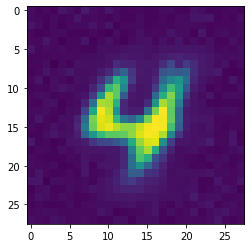

In [14]:
da = miss_data[0].to(device)
plt.imshow(model(da)[0].cpu().detach().numpy().reshape(-1, 28))

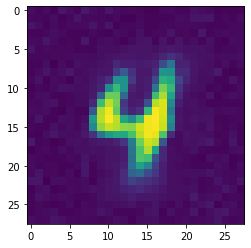

In [15]:
da = miss_data[1].to(device)
plt.imshow(model(da)[0].cpu().detach().numpy().reshape(-1, 28))

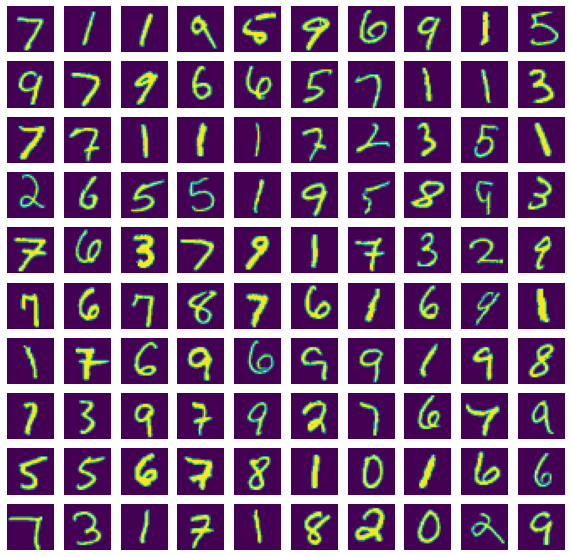

In [16]:
row = 10
col = 10
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(row, col, i+1)
    plt.imshow(miss_data[i].cpu().detach().numpy().reshape(28, 28))
    plt.axis('off')

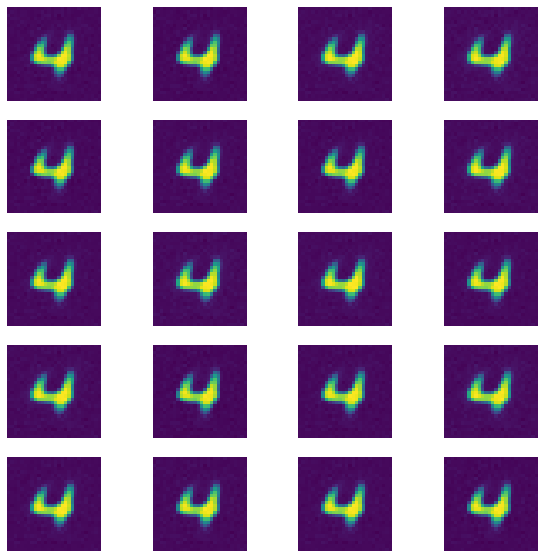

In [20]:
row = 5
col = 4
plt.figure(figsize=(10,10))

num = 0

while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(y_hat.cpu().detach().numpy().reshape(-1, 28, 28)[num])
    plt.axis('off')

In [18]:
v_utils.save_image(y_hat.cpu().reshape(-1, 28, 28)[:25],"../images/normal_gen_epoch{}.png".format(i+1), nrow=5)

TypeError: Cannot handle this data type: (1, 1, 25), |u1

In [8]:
image_check(y_hat.cpu().detach().numpy())

AttributeError: 'memoryview' object has no attribute 'numpy'

In [9]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)

X_embedded = tsne.fit_transform(metric_model.cog_list)

NameError: name 'metric_model' is not defined